In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
features = 11
output = 5

In [ ]:
class MultiLayerNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(features, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, output),
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
class WineDataset(Dataset):
  def __init__(self, list_data, nfeatures):
    self.data = list_data
    self.nfeatures = nfeatures
    

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    teste = self.data[idx]
    X, Y = teste[:self.nfeatures], teste[self.nfeatures:]
    return X, Y

In [ ]:
wine = np.loadtxt("winequality-red.csv", delimiter= ";", skiprows= 1)

n_samples = wine.shape[0]
n_test = int(2/3 * n_samples)
n_validation = int(2/3 * n_test)

np.random.shuffle(wine)

test = wine[n_test:]
train = wine[:n_validation]
validation = wine[n_validation:n_test]


In [ ]:
train_dataset = WineDataset(train, features)
validation_dataset = WineDataset(validation, features)
test_dataset = WineDataset(test, features)

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(train_dataset), shuffle=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando {device}")

Rodando cpu


In [ ]:
model = MultiLayerNetwork().to(device)

In [ ]:
lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr =1e-3)

In [ ]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [ ]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0

  for X, Y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    Y = Y.unsqueeze(1).float().to(device)
    pred = model(X)
    loss = lossfunc(pred, Y)

    #zera os gradientes acumulados
    optimizer.zero_grad()
    #computa os gradientes
    loss.backward()
    #anda na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor para obter valor float
    cumloss += loss.item()

  return cumloss / len(dataloader)

In [ ]:
def test(model, dataloader, lossfunc):
  model.eval()
  list_pred = []
  cumloss = 0.0

  with torch.no_grad():
    for X, Y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      Y = Y.unsqueeze(1).float().to(device)
      pred = model(X)
      list_pred.append(pred)
      loss = lossfunc(pred, Y)
      cumloss += loss.item()

  return cumloss / len(dataloader), list_pred

Epoch: 0; Train Loss: 50.74840545654297
Epoch: 10; Train Loss: 24.94301414489746
Epoch: 20; Train Loss: 11.032032012939453
Epoch: 30; Train Loss: 8.23278522491455
Epoch: 40; Train Loss: 6.585203647613525
Epoch: 50; Train Loss: 5.048166275024414
Epoch: 60; Train Loss: 3.6710736751556396
Epoch: 70; Train Loss: 2.5738794803619385
Epoch: 80; Train Loss: 1.8971844911575317
Epoch: 90; Train Loss: 1.4855295419692993
Epoch: 100; Train Loss: 1.2279467582702637
Epoch: 110; Train Loss: 1.0590349435806274
Epoch: 120; Train Loss: 0.9446013569831848
Epoch: 130; Train Loss: 0.8648722767829895
Epoch: 140; Train Loss: 0.8087588548660278
Epoch: 150; Train Loss: 0.7684410810470581
Epoch: 160; Train Loss: 0.739163875579834
Epoch: 170; Train Loss: 0.7173532843589783
Epoch: 180; Train Loss: 0.7004885673522949
Epoch: 190; Train Loss: 0.686878502368927
Epoch: 200; Train Loss: 0.6757785677909851
Epoch: 210; Train Loss: 0.666305661201477
Epoch: 220; Train Loss: 0.6582277417182922
Epoch: 230; Train Loss: 0.65104

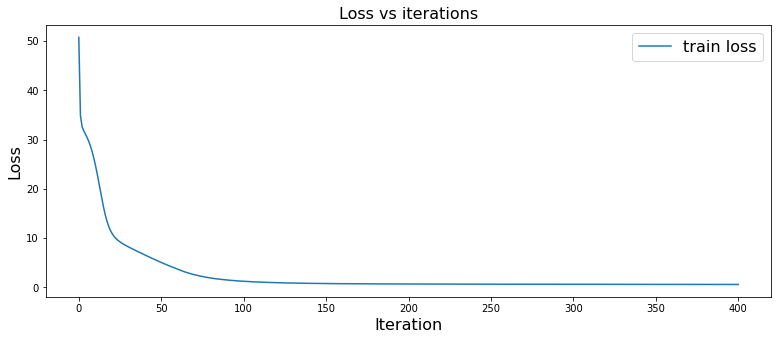

In [ ]:
epoch = 401
train_losses = []
for t in range(epoch):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t  % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  train_losses.append(train_loss)

losses = {"train loss": train_losses}
plot_losses(losses)

In [ ]:
validation_loss, list_pred = test(model, validation_dataloader, lossfunc)
print(f"Test Loss: {validation_loss}")

Test Loss: 0.6344168782234192
